In [50]:
# - Switch off warnings
import warnings
warnings.filterwarnings("ignore")

# - Import classes to represent time series data
from rockpool import TimeSeries, TSContinuous, TSEvent

# - Import `Module` classes to use
from rockpool.nn.modules import Rate, Linear

In [51]:
# - Import numpy
import numpy as np

# - Import the plotting library
import sys
!{sys.executable} -m pip install --quiet matplotlib rich
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

# - Rich printing
from rich import print

In [52]:
# - Define a feed-forward module with `N` neurons
N = 4
mod = Rate(N)
print(mod)

Rate  with shape (4,)

In [53]:
print(mod.state())
print(mod.parameters())
print(mod.simulation_parameters())

{'x': array([0., 0., 0., 0.])}

{'tau': array([0.02, 0.02, 0.02, 0.02]), 'bias': array([0., 0., 0., 0.]), 'threshold': array([0., 0., 0., 0.])}

{'dt': 0.001, 'noise_std': 0.0, 'act_fn': <function H_ReLU at 0x73709b5be840>}

In [54]:
T = 100
input_clocked = np.random.randn(T, N) * 3

# - Evolve the module with the input
output_clocked, new_state, recorded_state = mod(input_clocked)

# - Update the state of the module
mod = mod.set_attributes(new_state)

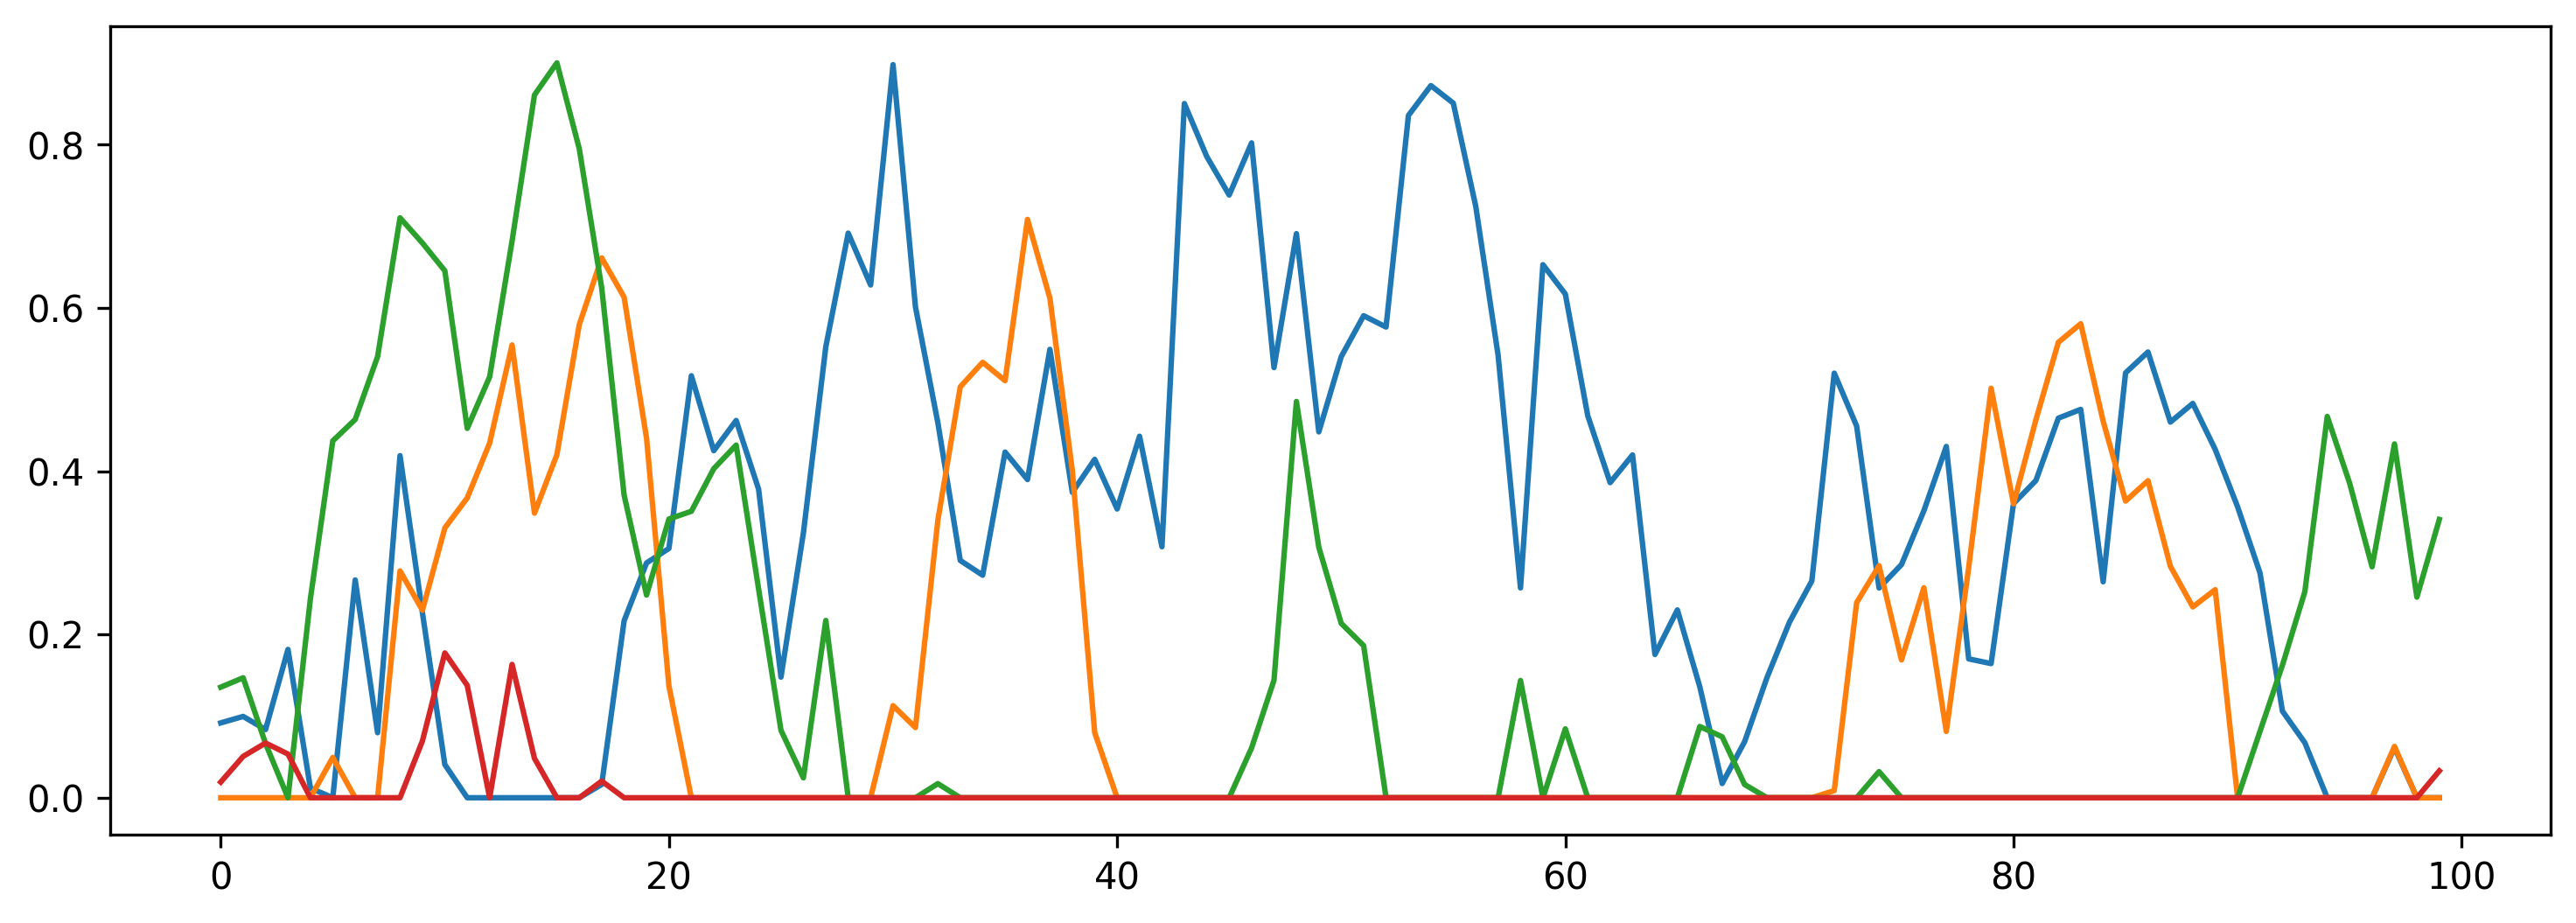

In [55]:
plt.plot(output_clocked[0])

In [56]:
# - Use the `.timed()` method to obtain a TimeSeries interface
tmod = mod.timed()
print(tmod)

TimedModuleWrapper  with shape (4, 4) {
    Rate '_module' with shape (4,)
} with Rate '_module' as module

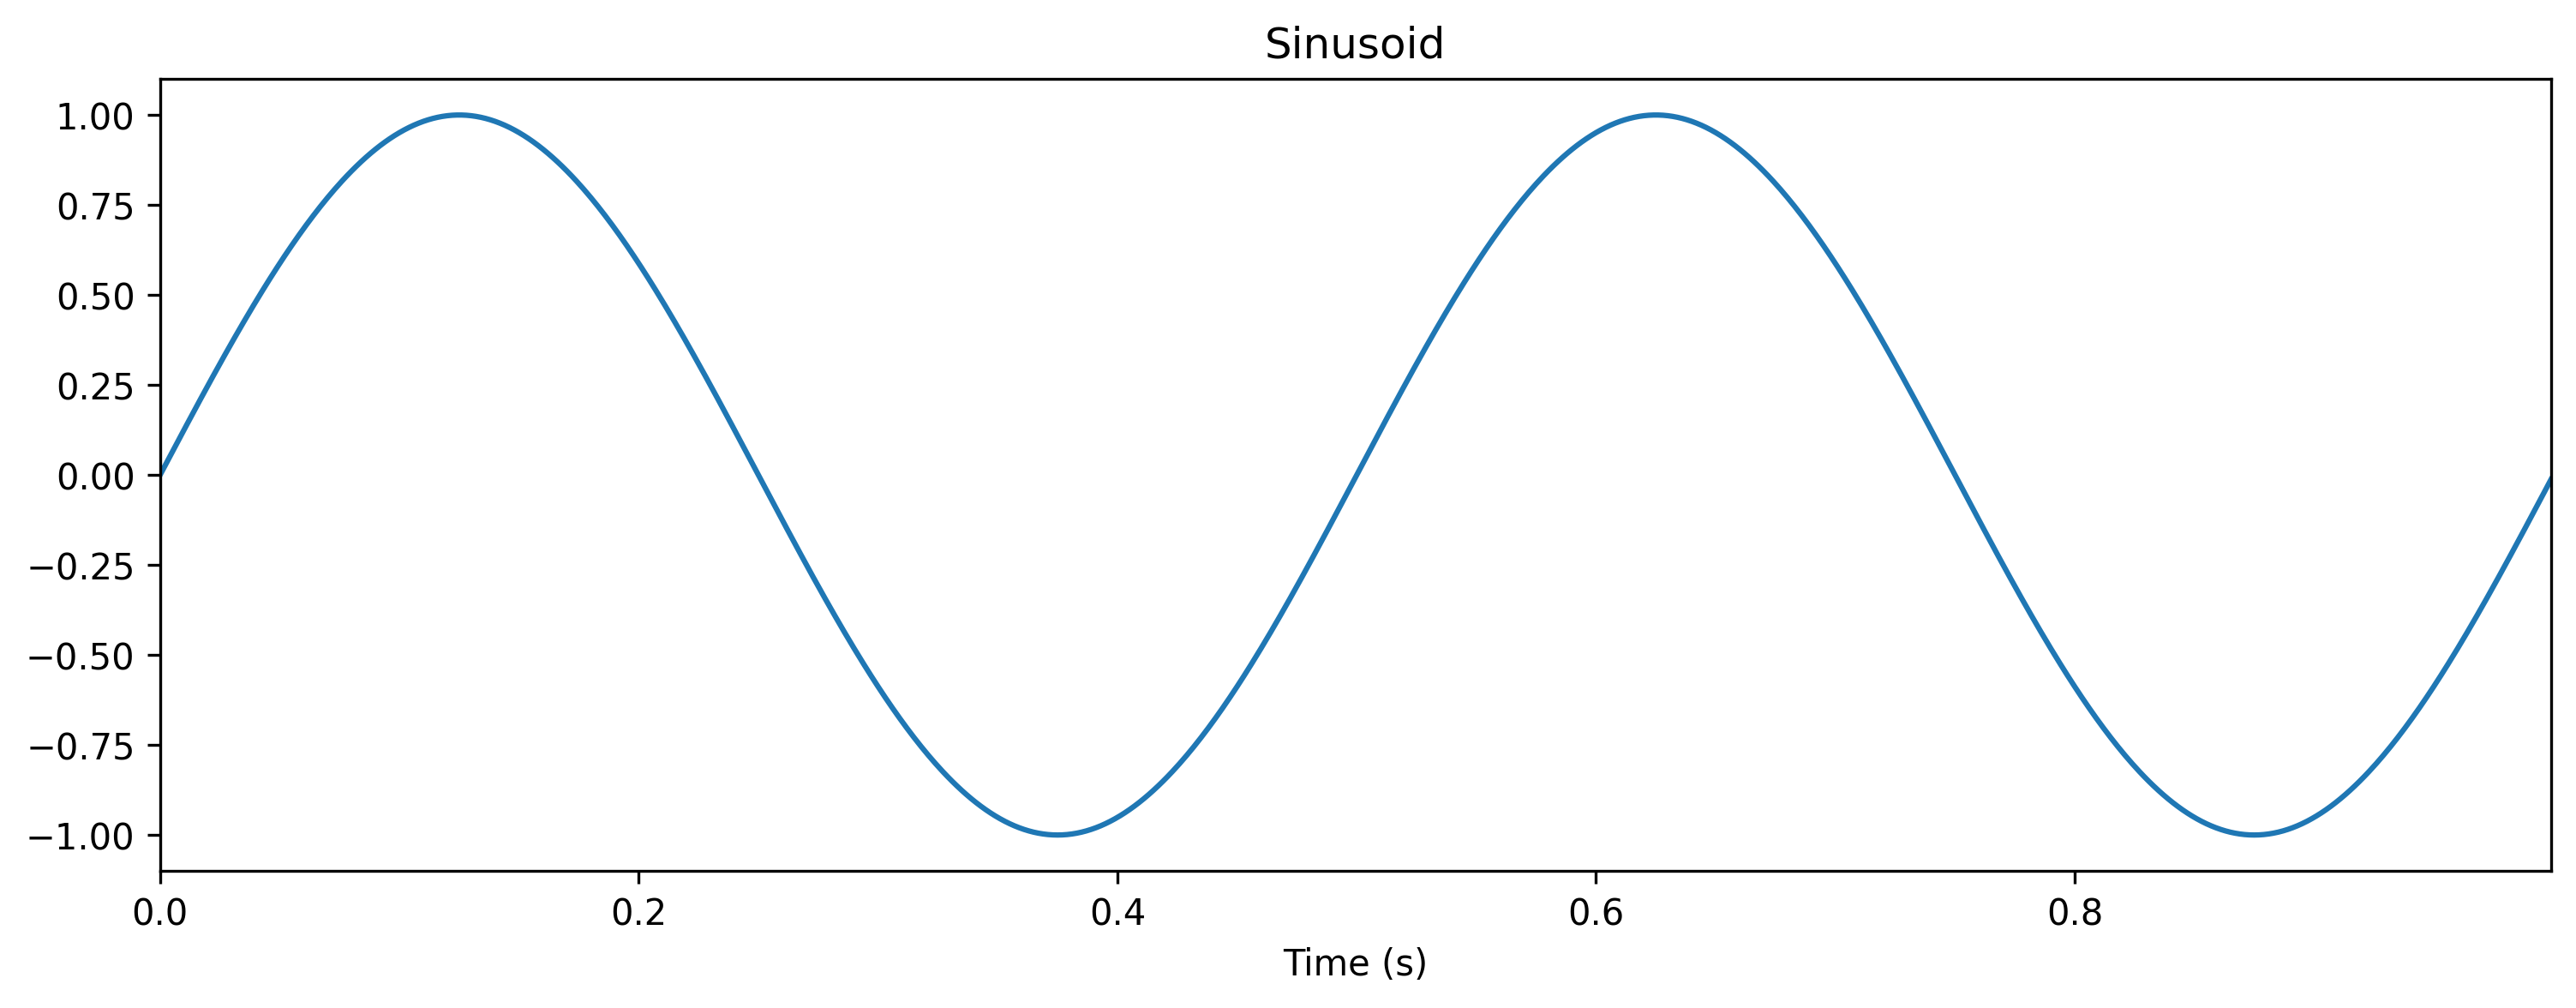

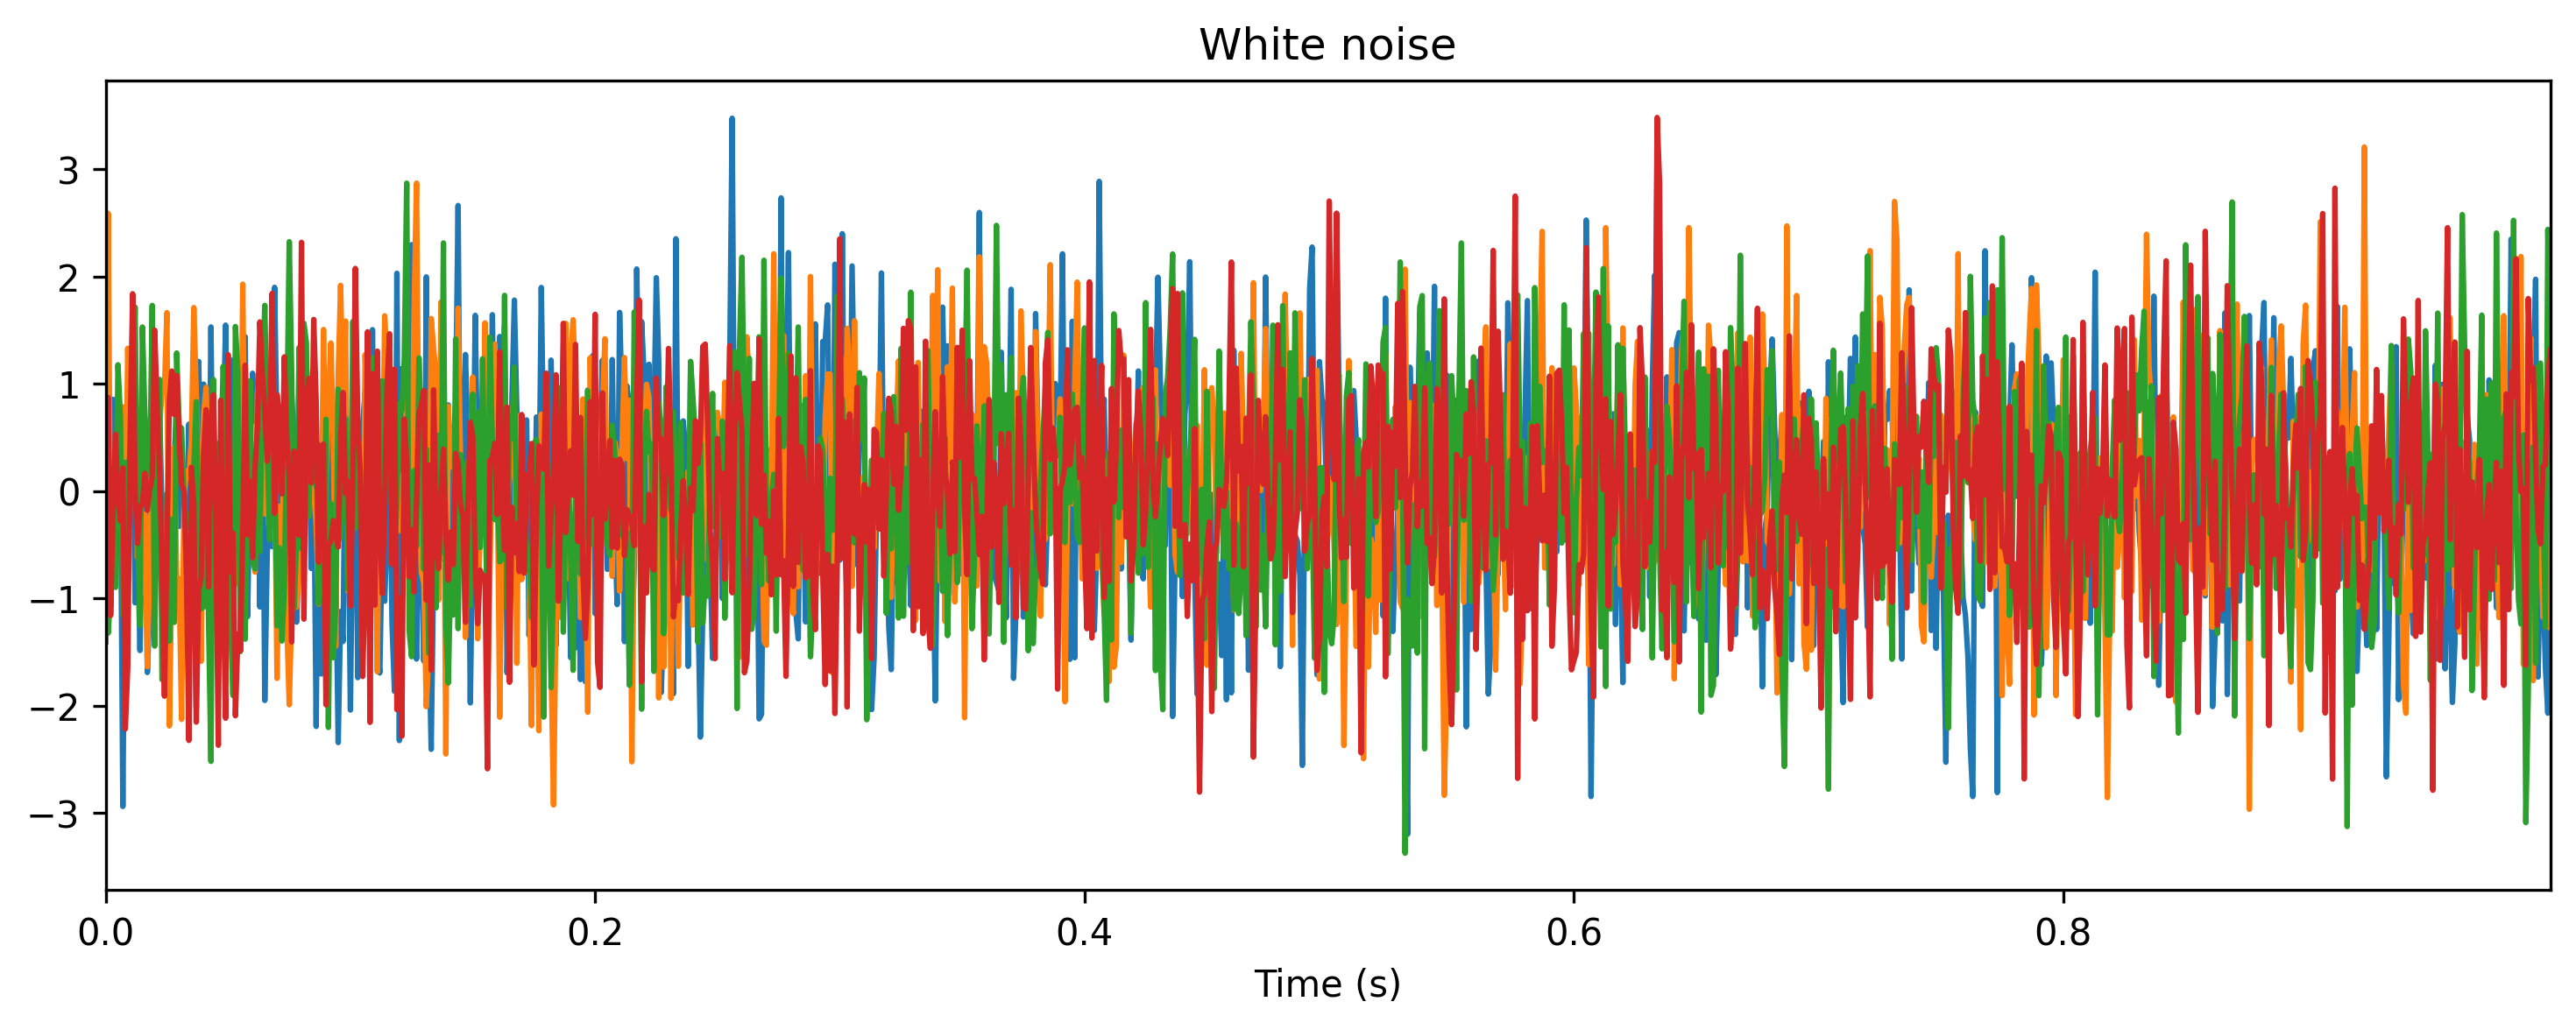

In [57]:
dt = 1e-3
T = 1000
time_base = np.arange(T) * dt

# - Generate a sinusoidal time series
freq = 2
ts_sin = TSContinuous(
    times=time_base,
    samples=np.sin(time_base * 2 * np.pi * freq),
    periodic=True,
    name="Sinusoid",
)
plt.figure()
ts_sin.plot()

# - Generate a noise time series
amp = 1
ts_noise = TSContinuous.from_clocked(
    samples=np.random.randn(T, N), dt=dt, periodic=True, name="White noise"
)
plt.figure()
ts_noise.plot()

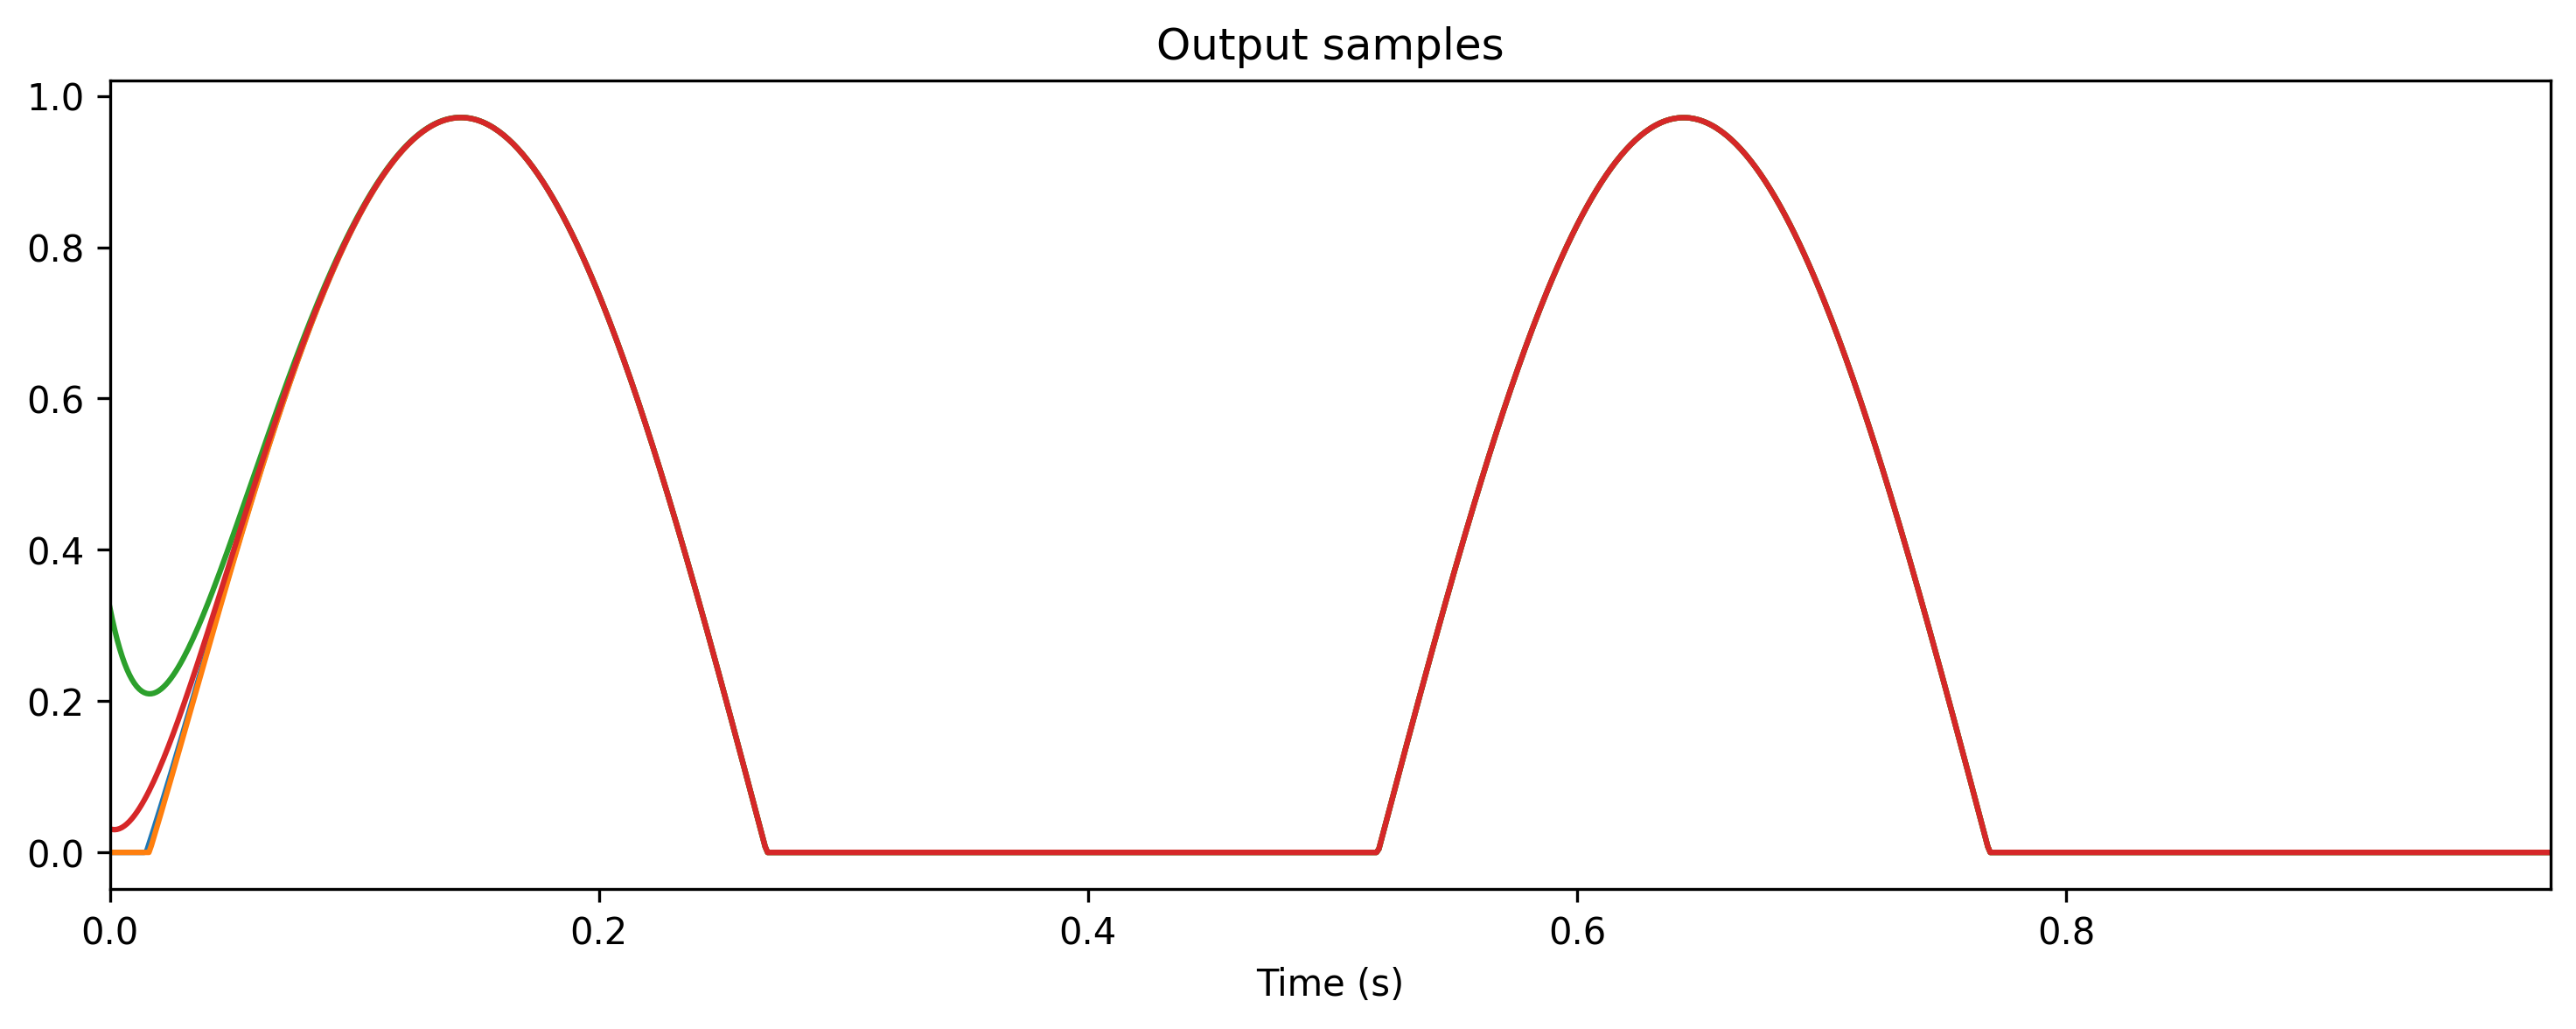

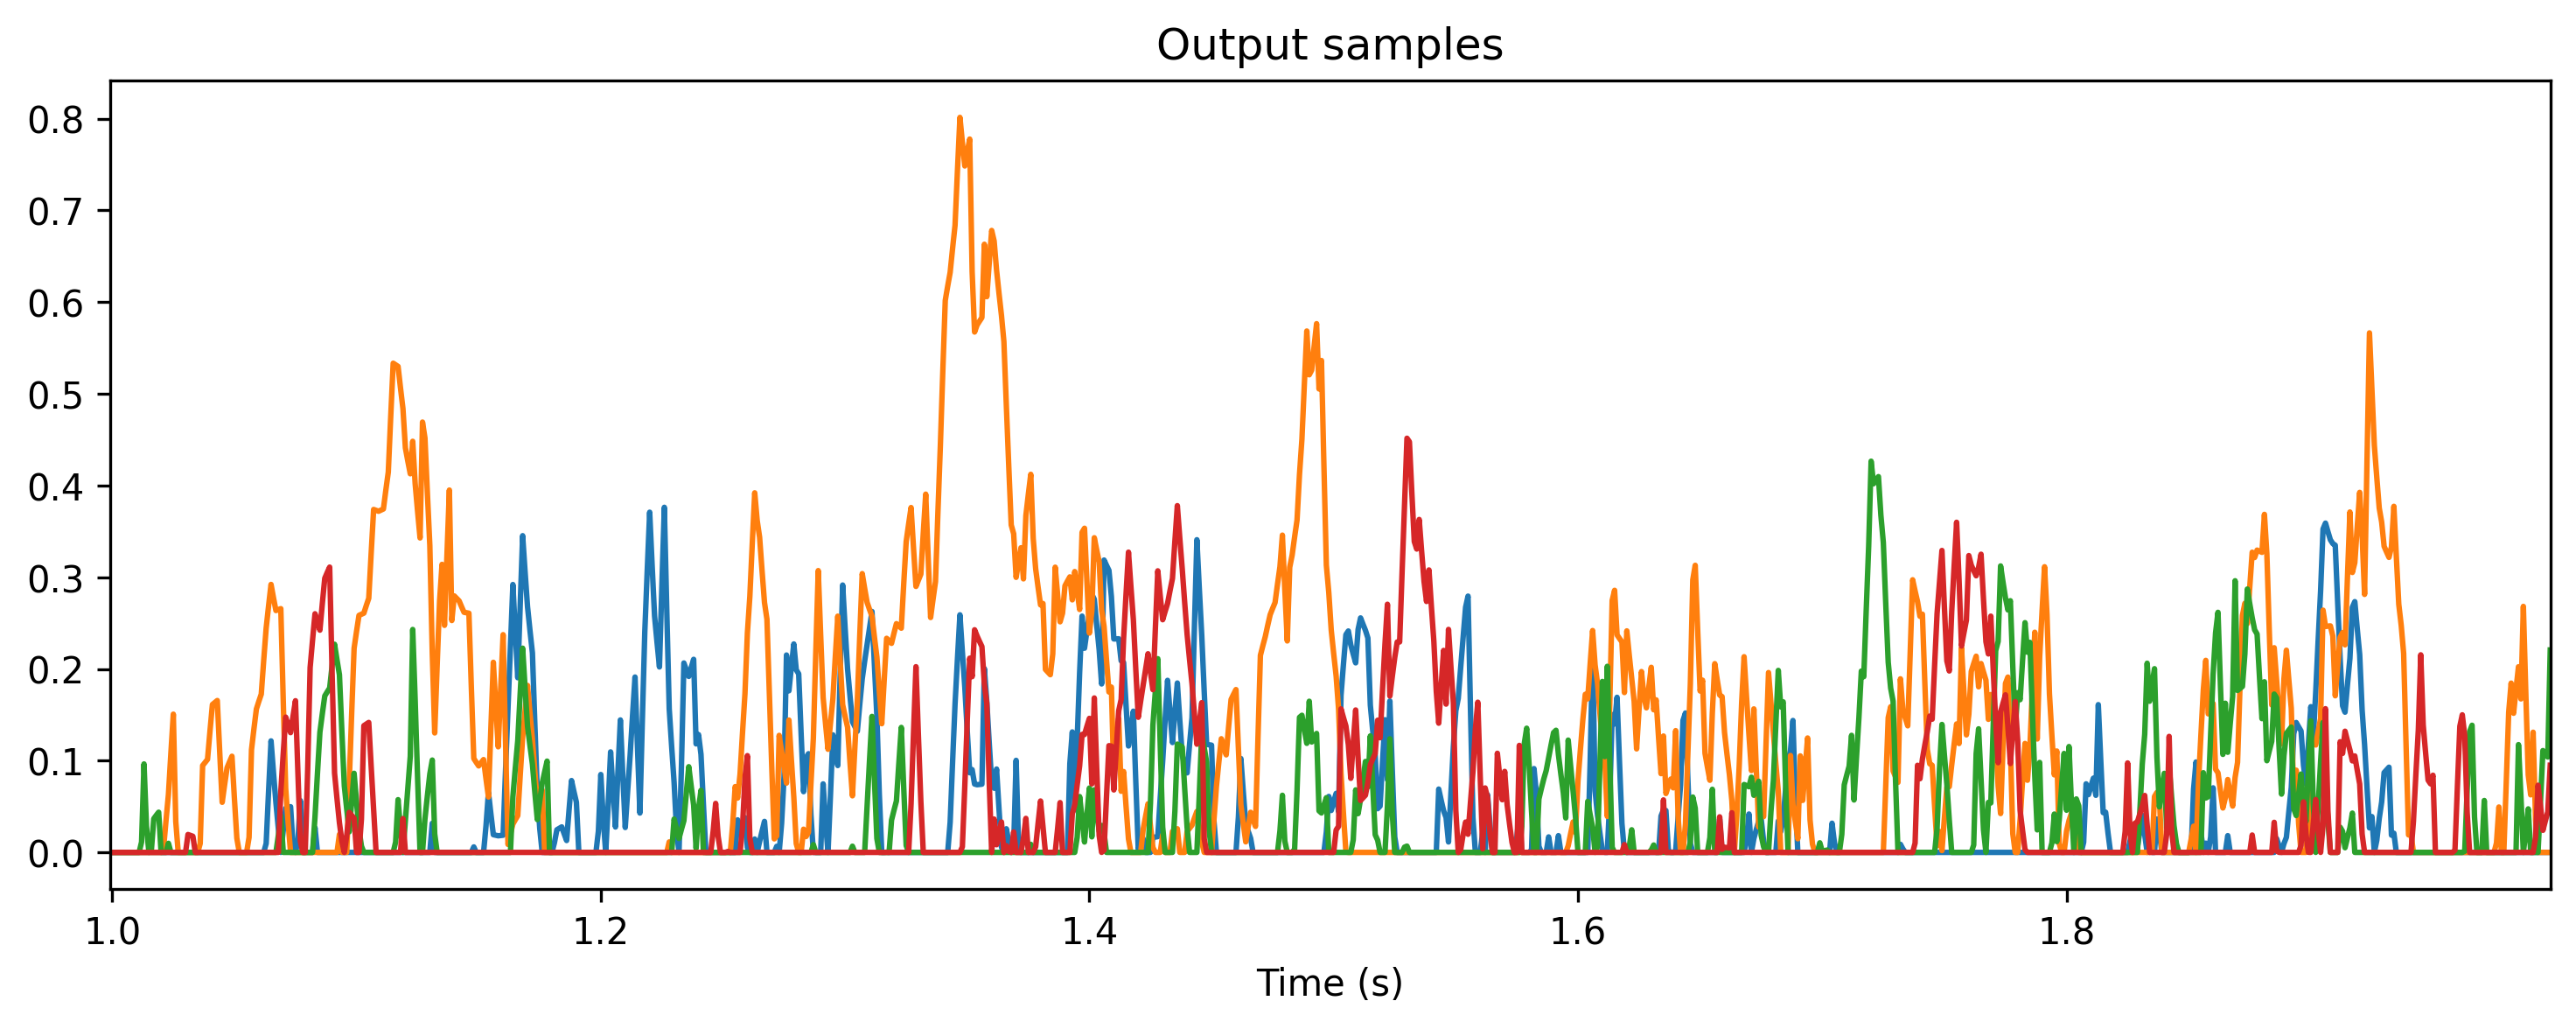

In [58]:
# - Evolve the timed module
output, new_state, _ = tmod(ts_sin)
plt.figure()
output.plot()

output, new_state, _ = tmod(ts_noise)
plt.figure()
output.plot()

In [59]:
print(new_state)   

{'x': array([-0.37964871, -0.14775802,  0.22067316,  0.09498718])}

In [60]:
# - Import the required modules
from rockpool.nn.modules import Linear, Rate

# - Import the `Sequential` combinator
from rockpool.nn.combinators import Sequential

# - Define the network size
input_size = 1
hidden_size = 10
output_size = 1

# - Build a sequential stack of modules
seqmod = Sequential(
    Linear((input_size, hidden_size)),
    Rate(hidden_size),
    Linear((hidden_size, input_size)),
)
print(seqmod)

ModSequential  with shape (1, 1) {
    Linear '0_Linear' with shape (1, 10)
    Rate '1_Rate' with shape (10,)
    Linear '2_Linear' with shape (10, 1)
}

In [61]:
input_clocked = np.random.rand(T, 1)
output, final_state, _ = seqmod(input_clocked)
print(final_state)

{
    '0_Linear': {},
    '1_Rate': {
        'x': array([-0.09230811,  0.22123827,  1.28326464, -0.56199358,  0.50437603,
       -1.16187546,  1.25289954,  0.03185594,  0.03038987, -0.1586448 ])
    },
    '2_Linear': {}
}

In [62]:
print(seqmod.parameters("weights"))

{
    '0_Linear': {
        'weight': array([[-0.17616486,  0.42222084,  2.44903867, -1.07253327,  0.9625734 ,
        -2.21737422,  2.39108858,  0.06079528,  0.05799737, -0.30276472]])
    },
    '2_Linear': {
        'weight': array([[-0.19296041],
       [ 0.6979016 ],
       [-0.68744638],
       [ 0.73068898],
       [ 0.38601776],
       [ 0.65024934],
       [ 0.0875674 ],
       [-0.13957991],
       [-0.58360368],
       [ 0.30914301]])
    }
}

In [63]:
# - Import the `OrderedDict` class
from collections import OrderedDict

# - Build an ordered dictionary of modules, specifying the name as each key
modules = OrderedDict([
    ("lin1", Linear((input_size, hidden_size))),
    ("rate1", Rate(hidden_size)),
    ("lin2", Linear((hidden_size, input_size))),
])

# - Build a `Sequential` network
seqmod = Sequential(modules)
print(seqmod)

ModSequential  with shape (1, 1) {
    Linear 'lin1' with shape (1, 10)
    Rate 'rate1' with shape (10,)
    Linear 'lin2' with shape (10, 1)
}

In [64]:
# - Start with an empty `Sequential` network
seqmod = Sequential()

# - Append modules in turn, specifying the submodule names
seqmod.append(Linear((input_size, hidden_size)), "lin1")
seqmod.append(Rate(hidden_size), "rate1")
seqmod.append(Linear((hidden_size, input_size)), "lin2")

print(seqmod)

ModSequential  with shape (1, 1) {
    Linear 'lin1' with shape (1, 10)
    Rate 'rate1' with shape (10,)
    Linear 'lin2' with shape (10, 1)
}

In [65]:
# - Import the required modules
from rockpool.nn.modules import Linear, Rate, Module

# - Parameters are specified using the `Parameter` and `State`
from rockpool.parameters import Parameter, State, SimulationParameter

# - Design the network architecture
#   Every module inherits from Module
class net(Module):
    # - Every module needs an `__init__()` method to specify parameters
    def __init__(self, shape: tuple, *args, **kwargs):
        # - Every module must call `super().__init__()`
        super().__init__(shape, *args, **kwargs)

        # - Configure weight parameters
        self.w_input = Parameter(
            shape=self.shape[0:2],
            family="weights",
            init_func=lambda size: np.random.normal(size=size),
        )
        self.w_output = Parameter(
            shape=self.shape[1:],
            family="weights",
            init_func=lambda size: np.random.normal(size=size),
        )

        # - Build submodules
        self.mod_recurrent = Rate((shape[1], shape[1]), has_rec=True)

    # - Every module needs an `evolve()` method
    def evolve(self, input, record: bool = False) -> (np.array, np.array, dict):
        # - Initialise output arguments
        new_state = {}
        record_dict = {}

        # - Pass input through the input weights and submodule
        x, mod_state, mod_record_dict = self.mod_recurrent(
            np.dot(input, self.w_input), record
        )

        # - Maintain the submodule state and recorded state dictionaries
        new_state.update({"mod_recurrent": mod_state})
        record_dict.update({"mod_recurrent": mod_record_dict})

        # - Pass data through the output weights
        output = np.dot(x, self.w_output)

        # - Return outputs
        return output, new_state, record_dict

In [66]:
# - Define the network size
input_size = 4
rec_size = 3
output_size = 2

# - Instantiate a module
net_mod = net(shape=(input_size, rec_size, output_size))
print(net_mod)

net  with shape (4, 3, 2) {
    Rate 'mod_recurrent' with shape (3, 3)
}

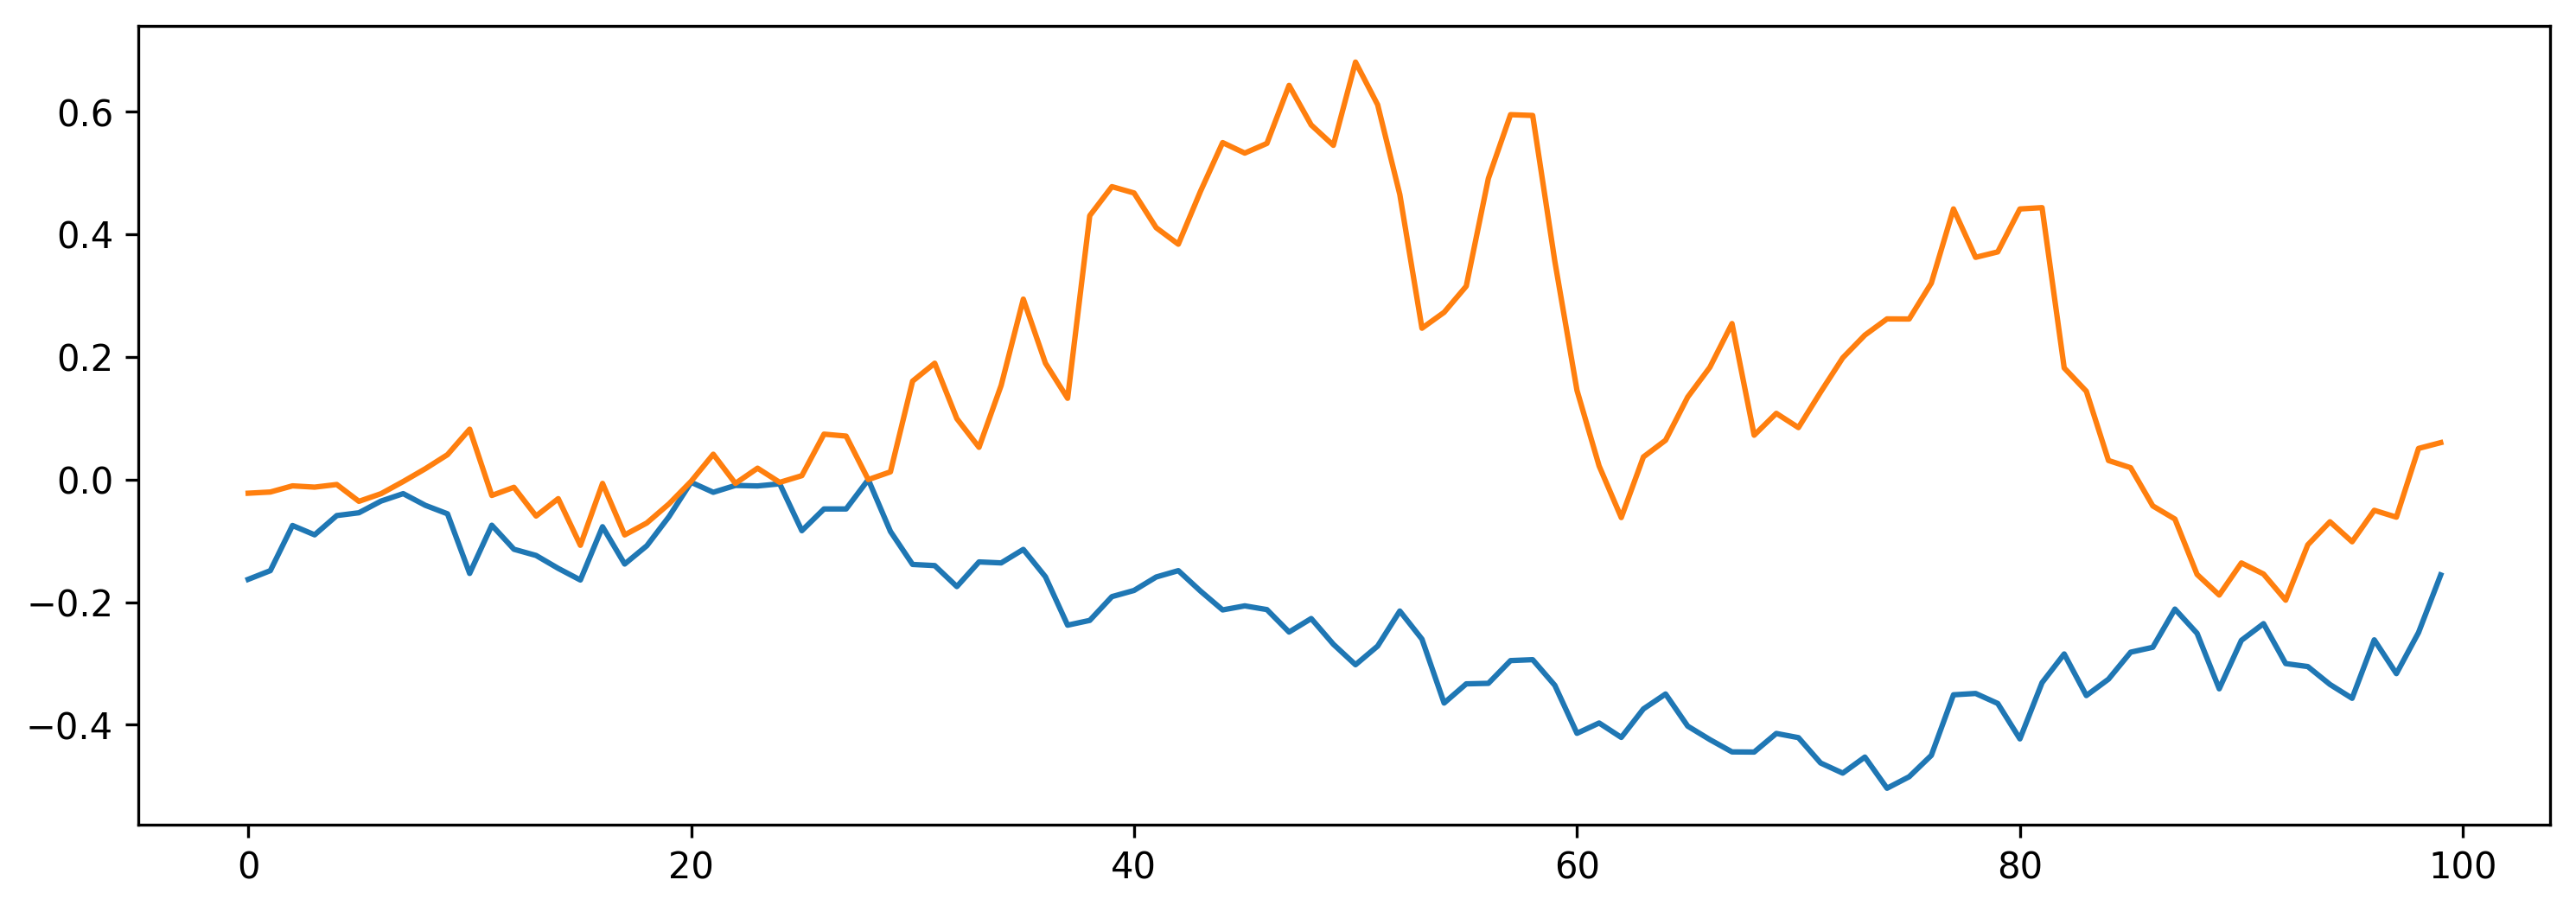

In [67]:
# - Define an input
T = 100
input = np.random.randn(T, input_size)

# - Evolve the module
output, new_state, recorded_state = net_mod(input)
net_mod = net_mod.set_attributes(new_state)
plt.plot(output[0])

In [68]:
print(net_mod.parameters())

{
    'w_input': array([[ 0.17202018, -0.3713499 ,  0.42165458],
       [-0.53889906, -0.17902674,  1.71355897],
       [ 0.20680509, -0.74636356, -0.58974554],
       [ 0.58666596,  0.82764741, -0.90538266]]),
    'w_output': array([[-2.06388117, -0.2814415 ],
       [-0.51165152,  1.32320782],
       [-0.52289709, -0.34272828]]),
    'mod_recurrent': {
        'w_rec': array([[ 0.11573573,  1.00548496, -1.47807422],
       [-0.83074515, -0.17121934, -0.18786302],
       [-0.62249151,  0.8615417 ,  0.66755627]]),
        'tau': array([0.02, 0.02, 0.02]),
        'bias': array([0., 0., 0.]),
        'threshold': array([0., 0., 0.])
    }
}

In [69]:
# - Define weights
weights_in = np.random.rand(input_size, rec_size) - 0.5
weights_rec = np.random.randn(rec_size, rec_sixze) / rec_size
weights_out = np.random.rand(rec_size, output_size) - 0.5

# - Set the weights
net_mod.w_input = weights_in
net_mod.mod_recurrent.w_rec = weights_rec
net_mod.w_output = weights_out

# - Display the network
print(net_mod.parameters())

NameError: name 'rec_sixze' is not defined